In [51]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import sklearn.cluster as skclust 
import copy
import scipy.stats as spstat

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])):
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_ind_fitnesses(filename):
    with open(filename) as file:
        csv_data = csv.reader(file,delimiter=',')
        lines = []
        for row in csv_data:
            for i in range(3,int(row[1])+3):
                lines.append([int(row[0]),i-3,float(row[i])*64])
    return lines


def load_controller_archive(filename):
    lines = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        coord = [0]*3
        state = 0
        nbr_param = 0
        i=0
        for row in csv_data:
            if(len(row) == 3):
                coord[0] = int(row[0])
                coord[1] = int(row[1])
                coord[2] = int(row[2])
                state = 1
                i=0
            elif(state == 1):
                nbr_param = int(row[0])
                state = 2
            elif(state == 2):
                nbr_param += int(row[0])
                state = 3
            elif(state == 3 and i < nbr_param):
                i+=1
            elif(state == 3 and i >= nbr_param):
                lines.append([coord[0],coord[1],coord[2],float(row[0])])
    return pd.DataFrame(data=lines,columns=["number of wheels","number of joints","number of sensors","fitness"])
                
def load_number_of_eval_per_gen(foldername,nbr_gen):
    nbr_eval_per_gen = [0]*nbr_gen
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            nbr_eval = 0
            for row in csv_data:
                if(len(row) == 4):
                    nbr_eval+=1
        nbr_eval_per_gen[gen] += nbr_eval
   # for i in range(1,len(nbr_eval_per_gen)):
    #    nbr_eval_per_gen[i] += nbr_eval_per_gen[i-1]
    return nbr_eval_per_gen
    
def load_controllers_fitnesses(foldername,nbr_gen):
    init_fits = [[] for _ in range(nbr_gen)]
    best_fits = [[] for _ in range(nbr_gen)]
    learn_prog = [[] for _ in range(nbr_gen)]
    learn_delta = [[] for _ in range(nbr_gen)]
    for filename in os.listdir(foldername):
        if(filename.split('_')[0] != "controllers"):
            continue
        gen = int(filename.split('_')[1])
        
        with open(foldername + '/' + filename) as file:
            csv_data = csv.reader(file,delimiter=',')
            best_fit = 0
            init_fit = 0
            counter = 0
            for row in csv_data:
                if(len(row) == 2):
                    if(init_fit == 0):
                        init_fit = float(row[0])
                        if(init_fit < 0):
                            init_fit = 0.5
                    if(best_fit < float(row[0])):
                        best_fit = float(row[0])
                    counter+=1
            learn_prog[gen].append((best_fit - init_fit))
            learn_delta[gen].append((best_fit - init_fit)/counter)
            best_fits[gen].append(best_fit)
            init_fits[gen].append(init_fit)
            
        
    return best_fits, init_fits ,learn_delta, learn_prog    
    
    
def load_descriptor(filename) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(len(row)-1) :
                desc.append(float(row[i]))
            descriptors.append(desc)
        return descriptors
    
def descOneId_to_descTwoIds(descriptors,pop_size):
    descriptors2 = []
    gen = 0
    ind = 0
    for desc in descriptors:
        if(desc[0] != 0 and desc[0]%pop_size == 0):
            gen+=1
            ind=0
        desc2 = [gen,ind] + desc[1:]
        ind+=1
        descriptors2.append(desc2)
    return descriptors2
        
def descriptors_to_nbr_of_types(descriptors):
    types_lines = []
    acc = 0
    mat = [[[0 for _ in range(16)] for _ in range(16)] for _ in range(16)]
    for desc in descriptors:
        if(mat[int(desc[6]*16)][int(desc[7]*16)][int(desc[8]*16)] == 0):
            mat[int(desc[6]*16)][int(desc[7]*16)][int(desc[8]*16)] = 1
            acc+=1
        if(desc[1] == 0):
            type_lines.append([desc[0],acc])
    return type_lines

def sparsness_per_gen(descriptors,pop_size):
    sparsness = []
    for i in range(int(len(descriptors)/pop_size)):
        tmp_desc = descriptors[i*pop_size:(i+1)*pop_size]
        spars = 0
        for o in range(len(tmp_desc)):
            for p in range(len(tmp_desc)):
                if(o==p):
                    continue
                dist = np.linalg.norm(np.array(tmp_desc[o][3:])-np.array(tmp_desc[p][3:]))
            spars += dist
        sparsness.append([i,spars/10])
    return sparsness

def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

def plot_hist_nbr_rob(title,data,organ,bins,nb_rob):
    fig = plt.gcf()
    fig.set_size_inches(25,10)
    ax = sns.histplot(data=data,multiple="stack",bins=bins,x='gen',hue=organ,palette="light:b")
    ax.set_ylabel("Number of robots",fontsize=20)
    ax.set_xlabel("Generations",fontsize=20)
    plt.title(title,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(range(1,nb_rob+1),labels=[1]*nb_rob,fontsize=20)
    plt.show()
    
    
def acc_number_eval(nbr_eval, best_fit):
    acc_nbr_eval = [0]
    for ne in nbr_eval:
        acc_nbr_eval.append(acc_nbr_eval[-1]+ne)
    for ne,fit in zip(acc_nbr_eval,best_fit):
        if(fit >= 0.95):
            return acc_nbr_eval, ne
        
def fitness_per_descriptor(descriptors,fitnesses):
    fit_per_desc = [dict() for _ in range(int(len(fitnesses)/20))]
    for fit,desc in zip(fitnesses,descriptors):
        if(fit[0] == desc[0] and fit[1] == desc[1]):
            organ_desc = str(int(desc[6]*16))+str(int(desc[7]*16)) + str(int(desc[8]*16))
            if(organ_desc in fit_per_desc[fit[0]]):
                fit_per_desc[fit[0]][organ_desc].append(fit[2])
            else:
                fit_per_desc[fit[0]][organ_desc] = [fit[2]]
    return fit_per_desc

def best_desc_per_gen(descriptors,fitnesses):
    best_fit = 0
    best_idx = 0
    best_desc = []
    for fit,i in zip(fitnesses,range(len(fitnesses))):
        if(fit[1] == 0 and fit[0] != 0):
            best_fit = 0
            best_desc.append([fit[0]-1,int(descriptors[best_idx][6]*16),int(descriptors[best_idx][7]*16),int(descriptors[best_idx][8]*16)])         
        if(fit[2] > best_fit):
            best_fit = fit[2]
            best_idx = i

    best_desc.append([fit[0],int(descriptors[best_idx][6]*16),int(descriptors[best_idx][7]*16),int(descriptors[best_idx][8]*16)])     
            
    return best_desc

def load_trajectory(filename):
    traj = []
    with open(filename) as file:
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            traj.append([float(row[0]),float(row[1])])
    return traj

In [3]:
arena = "Obstacles"
organ_lines = []

In [4]:
exp_folder = "/home/leni/are-logs/mnipes_noTiles_explo/organ_v3/"

In [5]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    
    for gen, bf, af in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,gen*2000,bf,af])
data_v3 = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness"])

In [6]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    descriptors = descOneId_to_descTwoIds(descriptors,20)
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","organ_v3"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","organ_v3"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","organ_v3"])

In [7]:
exp_folder = "/home/leni/are-logs/mnipes_noTiles_explo/organ_v2/"

In [8]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    
    for gen, bf, af in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,gen*2000,bf,af])
data_v2 = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness"])

In [30]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    descriptors = descOneId_to_descTwoIds(descriptors,20)
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","organ_v2"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","organ_v2"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","organ_v2"])

[[0, 0, 0.0], [0, 1, 0.0625], [0, 2, 0.0], [0, 3, 0.0625], [0, 4, 0.0], [0, 5, 0.0], [0, 6, 0.0625], [0, 7, 0.046875], [0, 8, 0.0], [0, 9, 0.0], [0, 10, 0.0], [0, 11, 0.0625], [0, 12, 0.0], [0, 13, 0.0], [0, 14, 0.0], [0, 15, 0.0], [0, 16, 0.0], [0, 17, 0.0], [0, 18, 0.0], [0, 19, 0.0], [0, 20, 0.0], [0, 21, 0.0], [0, 22, 0.0], [0, 23, 0.0], [0, 24, 0.0], [0, 25, 0.0], [0, 26, 0.0], [0, 27, 0.0], [0, 28, 0.0], [0, 29, 0.0625], [0, 30, 0.15625], [0, 31, 0.0], [1, 0, 0.15625], [1, 1, 0.0], [1, 2, 0.15625], [1, 3, 0.0], [1, 4, 0.15625], [1, 5, 0.0625], [1, 6, 0.0], [1, 7, 0.125], [1, 8, 0.0625], [1, 9, 0.171875], [1, 10, 0.0], [1, 11, 0.109375], [1, 12, 0.15625], [1, 13, 0.171875], [1, 14, 0.109375], [1, 15, 0.0625], [1, 16, 0.15625], [1, 17, 0.0625], [1, 18, 0.140625], [1, 19, 0.140625], [1, 20, 0.140625], [1, 21, 0.0625], [1, 22, 0.0625], [1, 23, 0.0], [1, 24, 0.0625], [1, 25, 0.0], [1, 26, 0.125], [1, 27, 0.0625], [1, 28, 0.0], [1, 29, 0.0], [1, 30, 0.0625], [1, 31, 0.15625], [2, 0, 0.

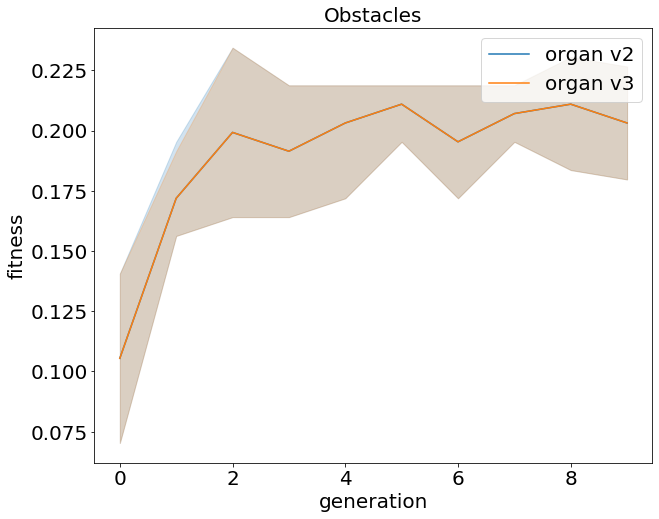

In [31]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
ax = sns.lineplot(data=data_v2,x="generation",y="best fitness",label="organ v2")
sns.lineplot(data=data_v3,x="generation",y="best fitness",label="organ v3")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("fitness")
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

<Figure size 360x360 with 0 Axes>

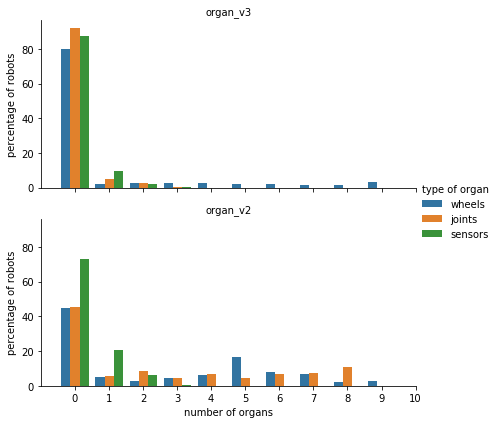

In [13]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 10))) 

In [23]:
arena = "Obstacles"
organ_lines = []

In [24]:
exp_folder = "/home/leni/are-logs/mnipes_simple_explo/organ_v2/"

In [25]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    
    for gen, bf, af in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,gen*2000,bf,af])
data_v2 = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness"])

In [26]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","organ_v2"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","organ_v2"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","organ_v2"])

mnipes_30_10_17-21-57-7931-2278294842
mnipes_30_10_17-21-51-1587-3526783848
mnipes_30_10_17-24-14-4315-630596472
mnipes_30_10_17-21-57-7799-2210701485


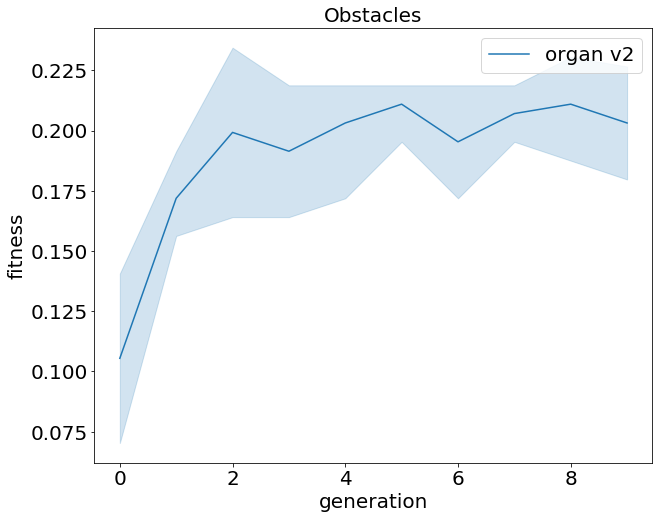

In [27]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
ax = sns.lineplot(data=data_v2,x="generation",y="best fitness",label="organ v2")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("fitness")
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

<Figure size 360x360 with 0 Axes>

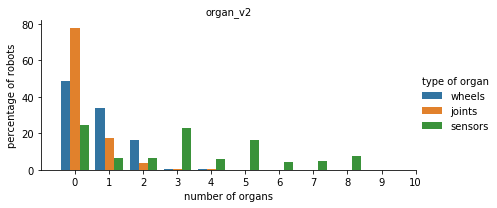

In [28]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 10))) 

[[1, 3, 0], [1, 3, 0], [2, 5, 1], [0, 8, 1]]


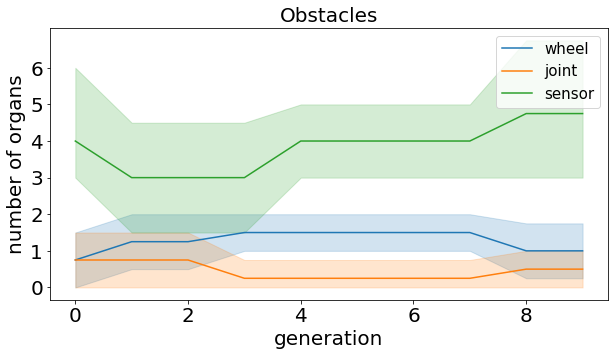

In [29]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xticks(range(0,10,2))
ax.set_yticks(range(7))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena, fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==9]["wheel"].values
joints_array = data.loc[data["generation"]==9]["joint"].values
sensors_array = data.loc[data["generation"]==9]["sensor"].values
bda = [[w,s,j]for w,s,j in zip(wheels_array,sensors_array,joints_array)]
print(bda)

In [2]:
arena = "Obstacles"
organ_lines = []

In [5]:
exp_folder = "/home/leni/are-logs/mnipes_simple_explo2/"

In [6]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    
    for gen, bf, af in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,gen*2000,bf,af])
data_v2 = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness"])

In [7]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","organ_v2"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","organ_v2"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","organ_v2"])

mnipes_1_11_16-37-50-947-1024337995
mnipes_1_11_16-37-39-9542-2458026775


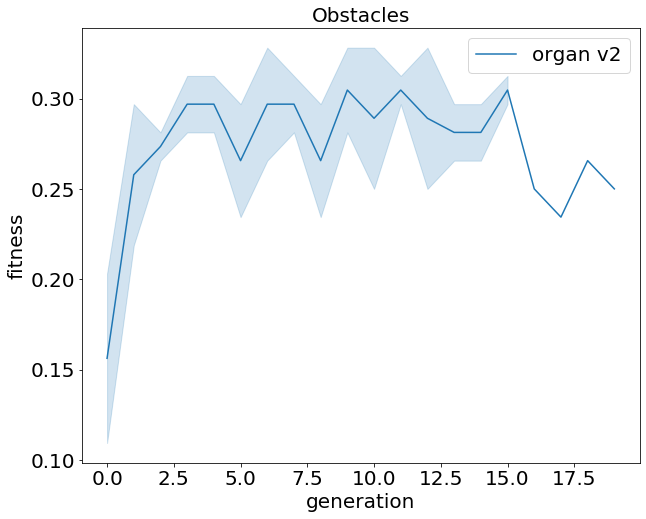

In [8]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
ax = sns.lineplot(data=data_v2,x="generation",y="best fitness",label="organ v2")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("fitness")
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

<Figure size 360x360 with 0 Axes>

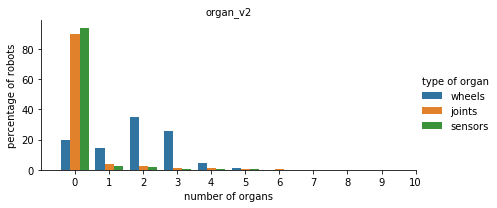

In [9]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 10))) 

[[3, 0, 0], [2, 0, 0]]


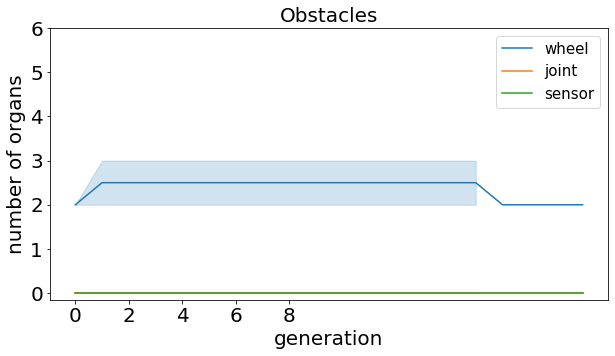

In [10]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xticks(range(0,10,2))
ax.set_yticks(range(7))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
ax.set_title(arena, fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==9]["wheel"].values
joints_array = data.loc[data["generation"]==9]["joint"].values
sensors_array = data.loc[data["generation"]==9]["sensor"].values
bda = [[w,s,j]for w,s,j in zip(wheels_array,sensors_array,joints_array)]
print(bda)

In [6]:
exp_folder = "/home/leni/are-logs/robustness_test/"

In [26]:
fitnesses_1 = load_ind_fitnesses(exp_folder + "/same/robustness_test_3_11_11-30-43-3774-664215007/fitnesses.csv") 
fitnesses_1 = [l + ["same"] for l in fitnesses_1]
fitnesses_2 = load_ind_fitnesses(exp_folder + "/tiles_obst2/robustness_test_3_11_11-32-37-7071-4183977562/fitnesses.csv") 
fitnesses_2 = [l + ["more realistic"] for l in fitnesses_2]
fitnesses_3 = load_ind_fitnesses(exp_folder + "/tiles_obst2_noflat/robustness_test_3_11_11-34-29-9634-3656628993/fitnesses.csv") 
fitnesses_3 = [l + ["more difficult"] for l in fitnesses_3]
fitnesses = fitnesses_1 + fitnesses_2

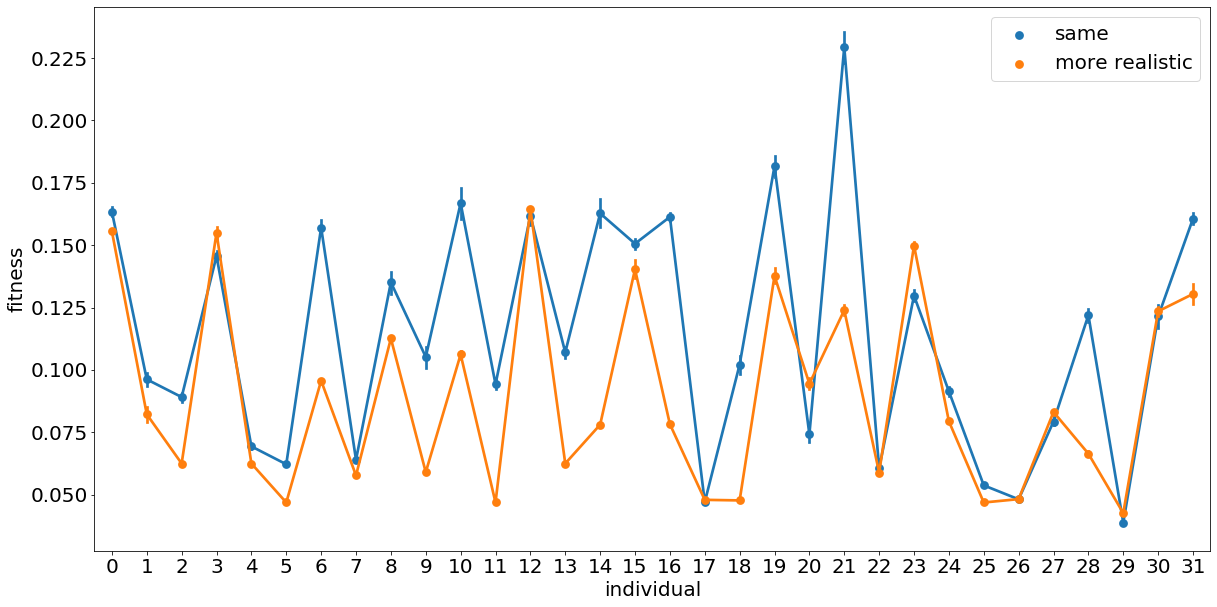

In [32]:
data = pd.DataFrame(data=fitnesses,columns=["generation","individual","fitnesses","type"])
fig = plt.gcf()
fig.set_size_inches(20, 10)
ax = sns.pointplot(data=data,x="individual",y="fitnesses",hue="type")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("fitness")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

In [56]:
exp_folder = "/home/leni/are-logs/robustness_test2/"

In [69]:
fitnesses_1 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/same/robustness_test_6_11_15-35-11-1521-2106929753/fitnesses.csv") 
fitnesses_1 = [l + ["initial"] for l in fitnesses_1]
fitnesses_2 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/retraining2/mnipes_14_11_11-44-44-4019-771861670/fitnesses.csv") 
indexes = [0,6,13,16,20]
i = 0
for l in fitnesses_2:
    if(i == 5):
        i = 0
    l[1] = indexes[i]
    i+=1
fitnesses_2 = [l + ["retrained"] for l in fitnesses_2]

#fitnesses_2 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/tiles/robustness_test_6_11_13-49-54-4398-1137054334/fitnesses.csv") 
#fitnesses_2 = [l + ["with tiles"] for l in fitnesses_2]
#fitnesses_3 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/tiles_obst2/robustness_test_6_11_13-52-28-8106-3780900535/fitnesses.csv") 
#fitnesses_3 = [l + ["with tiles + obstacle 2"] for l in fitnesses_3]
fitnesses_4 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/tiles_noflat/robustness_test_9_11_15-35-51-1856-2491736018/fitnesses.csv") 
fitnesses_4 = [l + ["hard"] for l in fitnesses_4]
fitnesses = fitnesses_1 + fitnesses_2 + fitnesses_4

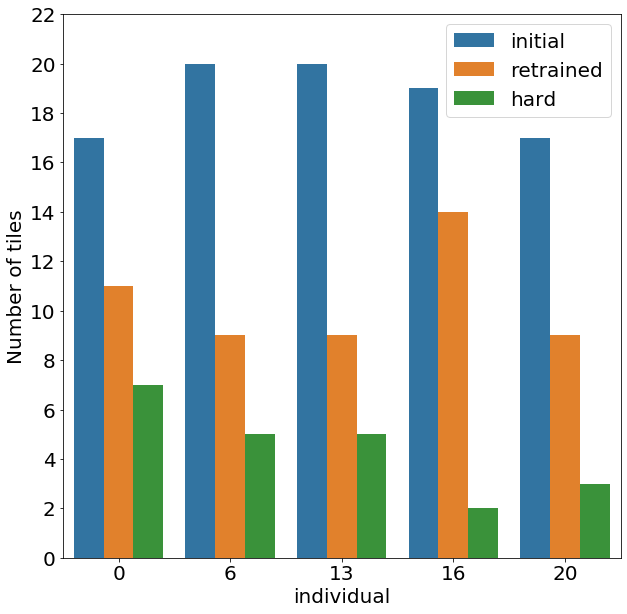

In [71]:
data = pd.DataFrame(data=fitnesses,columns=["generation","individual","fitnesses","type"])
data = data[data["individual"].isin([0,6,13,16,20])]
fig = plt.gcf()
fig.set_size_inches(10, 10)
ax = sns.barplot(data=data,x="individual",y="fitnesses",hue="type",estimator=np.max,ci=None)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_yticks(range(0,24,2))
ax.set_ylabel("Number of tiles")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

In [62]:
fitnesses_1 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/same/robustness_test_6_11_15-35-11-1521-2106929753/fitnesses.csv") 
fitnesses_1 = [l + ["initial"] for l in fitnesses_1]
fitnesses_2 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/retraining/mnipes_8_11_15-49-0-488-3385659389/fitnesses.csv") 
indexes = [0,6,13,16,20]
i = 0
for l in fitnesses_2:
    if(i == 5):
        i = 0
    l[1] = indexes[i]
    i+=1
fitnesses_2 = [l + ["retrained"] for l in fitnesses_2]

fitnesses_3 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/tiles/robustness_test_6_11_13-49-54-4398-1137054334/fitnesses.csv") 
fitnesses_3 = [l + ["medium"] for l in fitnesses_3]
#fitnesses_3 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/tiles_obst2/robustness_test_6_11_13-52-28-8106-3780900535/fitnesses.csv") 
#fitnesses_3 = [l + ["with tiles + obstacle 2"] for l in fitnesses_3]
#fitnesses_4 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/tiles_noflat/robustness_test_9_11_15-35-51-1856-2491736018/fitnesses.csv") 
#fitnesses_4 = [l + ["hard"] for l in fitnesses_4]
fitnesses = fitnesses_1 + fitnesses_2 + fitnesses_3

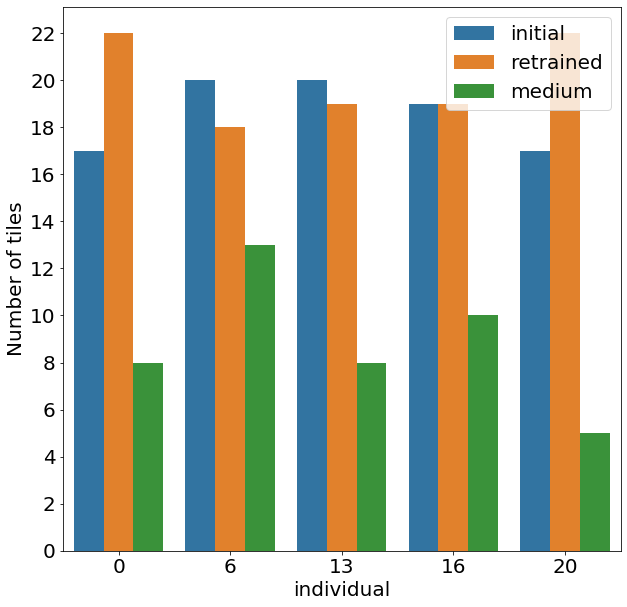

In [67]:
data = pd.DataFrame(data=fitnesses,columns=["generation","individual","fitnesses","type"])
data = data[data["individual"].isin([0,6,13,16,20])]
fig = plt.gcf()
fig.set_size_inches(10, 10)
ax = sns.barplot(data=data,x="individual",y="fitnesses",hue="type",estimator=np.max,ci=None)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_yticks(range(0,24,2))
ax.set_ylabel("Number of tiles")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

(-1, 1)

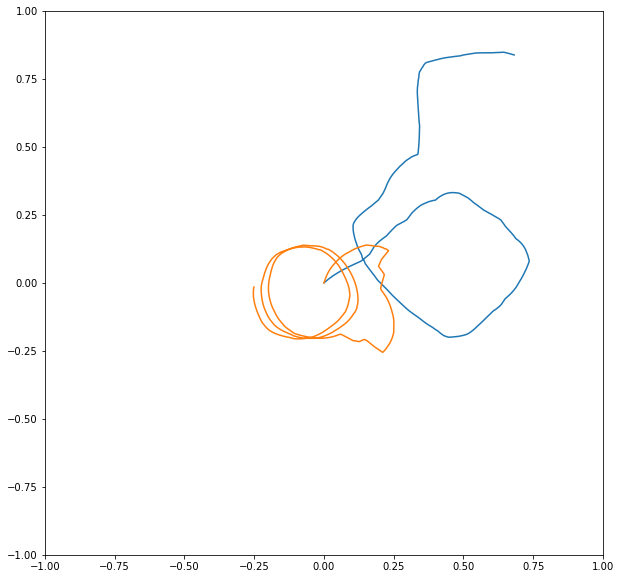

In [47]:

traj_1 = load_trajectory("/home/leni/are-logs/robustness_test2/same/robustness_test_6_11_15-35-11-1521-2106929753/traj_3_0")
traj_2 = load_trajectory("/home/leni/are-logs/robustness_test2/tiles/robustness_test_6_11_13-49-54-4398-1137054334/traj_3_0")
X = [t[0] for t in traj_1]
Y = [t[1] for t in traj_1]
x = [t[0] for t in traj_2]
y = [t[1] for t in traj_2]
plt.figure(figsize=[10,10])
plt.plot(X,Y,x,y)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [37]:
arena = "Obstacles - Medium"
organ_lines = []

In [38]:
exp_folder = "/home/leni/are-logs/robustness_test2/retraining/"

In [39]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    
    for gen, bf, af in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,gen*2000,bf,af])
data_v2 = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness"])

In [40]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","organ_v2"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","organ_v2"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","organ_v2"])

mnipes_8_11_15-49-0-488-3385659389


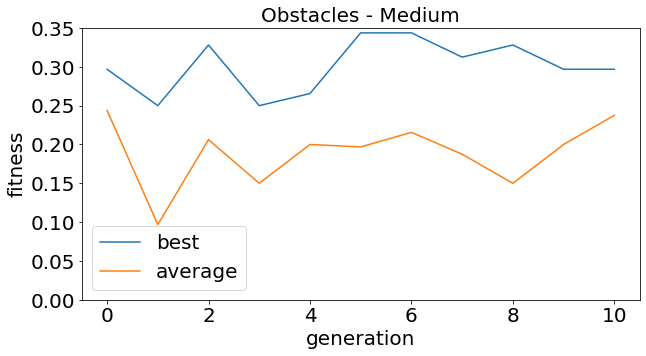

In [41]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax = sns.lineplot(data=data_v2,x="generation",y="best fitness",label="best")
sns.lineplot(data=data_v2,x="generation",y="average fitness",label="average")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("fitness")
ax.set_ylim(0,0.35)
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

<Figure size 360x360 with 0 Axes>

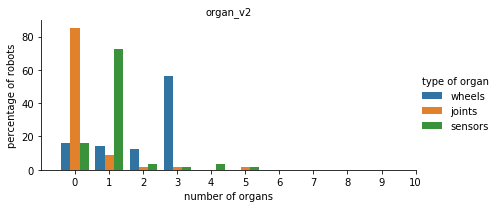

In [27]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 10))) 

[]


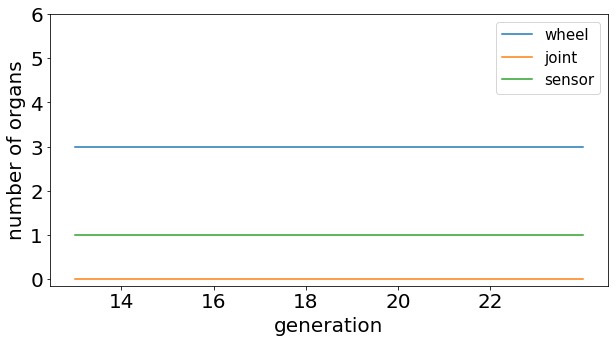

In [29]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xticks(range(14,24,2))
ax.set_yticks(range(7))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
#ax.set_title(arena, fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==9]["wheel"].values
joints_array = data.loc[data["generation"]==9]["joint"].values
sensors_array = data.loc[data["generation"]==9]["sensor"].values
bda = [[w,s,j]for w,s,j in zip(wheels_array,sensors_array,joints_array)]
print(bda)

In [20]:
fitnesses_1 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/same/robustness_test_9_11_15-49-51-1657-2154181581/fitnesses.csv") 
fitnesses_1 = [l + ["simple",0] for l in fitnesses_1]
#fitnesses_2 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/tiles/robustness_test_9_11_15-50-15-5228-2945149606/fitnesses.csv") 
#fitnesses_2 = [l + ["with tiles"] for l in fitnesses_2]
#fitnesses_3 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/tiles_obst2/robustness_test_9_11_15-50-34-4923-2851958411/fitnesses.csv") 
#fitnesses_3 = [l + ["with tiles + obstacle 2"] for l in fitnesses_3]
fitnesses_4 = load_ind_fitnesses("/home/leni/are-logs/robustness_test2/tiles_obst2_noflat/robustness_test_9_11_15-51-3-3867-522000250/fitnesses.csv") 
fitnesses_4 = [l + ["complex",1] for l in fitnesses_4]
fitnesses = fitnesses_1 + fitnesses_4

      generation  individual  fitnesses    type  index
30             0          30   0.015625  simple      0
94             2          30   0.015625  simple      0
830           25          30   0.015625  simple      0
1246          38          30   0.015625  simple      0
1662          51          30   0.015625  simple      0
...          ...         ...        ...     ...    ...
2391          74          23   0.328125  simple      0
715           22          11   0.343750  simple      0
811           25          11   0.343750  simple      0
1175          36          23   0.343750  simple      0
2571          80          11   0.343750  simple      0

[6400 rows x 5 columns]


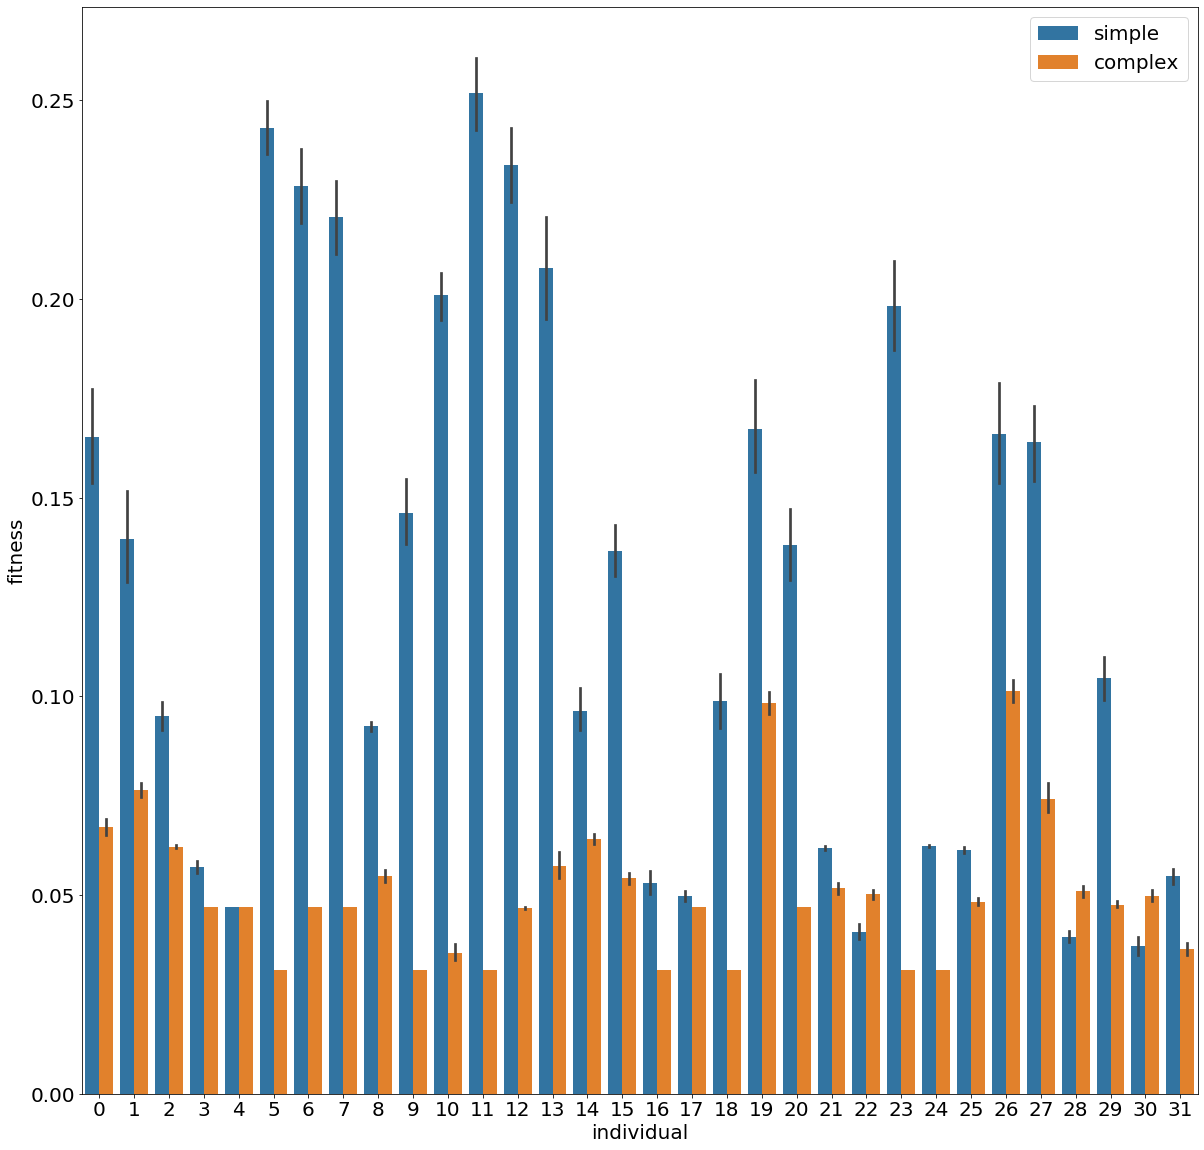

In [22]:
data = pd.DataFrame(data=fitnesses,columns=["generation","individual","fitnesses","type","index"])
data.sort_values(by=["fitnesses","index"],inplace=True)
print(data)
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax = sns.barplot(data=data,x="individual",y="fitnesses",hue="type")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("fitness")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

In [52]:
arena = "Obstacles - Hard"
organ_lines = []
exp_folder = "/home/leni/are-logs/robustness_test2/retraining2/"

In [53]:
lines = []
for folder in os.listdir(exp_folder):
    neval, best_ids, best_fit, avg_fit, pop_size = load_all_fitnesses(exp_folder + folder + "/fitnesses.csv",0)
    
    for gen, bf, af in zip(range(len(best_fit)),best_fit,avg_fit):
        lines.append([gen,gen*2000,bf,af])
data_v2 = pd.DataFrame(data=lines,columns=["generation","max number of evaluations","best fitness","average fitness"])

In [54]:
fit_lines = []
desc_lines = []
type_lines = []
best_desc_lines = []
for folder in os.listdir(exp_folder):
    print(folder)
    descriptors = load_descriptor(exp_folder + folder + "/MD_Cart_WDH.csv")
    type_lines += descriptors_to_nbr_of_types(descriptors)
    fitnesses = load_ind_fitnesses(exp_folder + folder + "/fitnesses.csv")
    fit_lines += fitnesses
    best_desc_lines += best_desc_per_gen(descriptors,fitnesses)
    for desc in descriptors:
        desc_lines.append([desc[0],str(desc[1]),desc[6]*16,desc[7]*16,desc[8]*16])
        
wheels = [0 for _ in range(16)]
joints = [0 for _ in range(16)]
sensors = [0 for _ in range(16)]

total=0
for fit,desc in zip(fit_lines,desc_lines):
    wheels[int(desc[2])]+=1
    joints[int(desc[4])]+=1
    sensors[int(desc[3])]+=1
    total+=1

for i in range(len(wheels)):
    wheels[i]=wheels[i]/total*100
    joints[i]=joints[i]/total*100
    sensors[i]=sensors[i]/total*100


for i,w in zip(range(len(wheels)),wheels):
    organ_lines.append([str(i),w,"wheels","organ_v2"])
for i,j in zip(range(len(joints)),joints):
    organ_lines.append([str(i),j,"joints","organ_v2"])
for i,s in zip(range(len(sensors)),sensors):
    organ_lines.append([str(i),s,"sensors","organ_v2"])

mnipes_14_11_11-44-44-4019-771861670


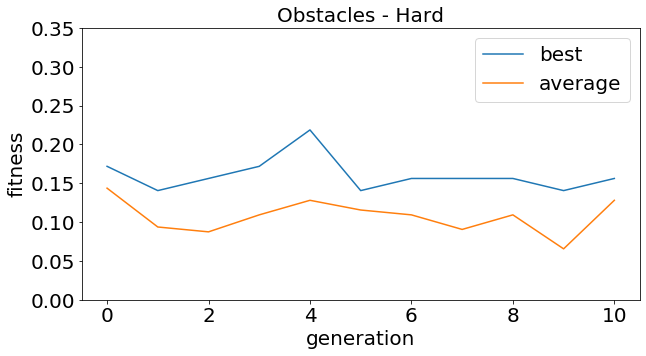

In [55]:
fig = plt.gcf()
fig.set_size_inches(10, 5)
ax = sns.lineplot(data=data_v2,x="generation",y="best fitness",label="best")
sns.lineplot(data=data_v2,x="generation",y="average fitness",label="average")
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_title(arena,fontsize=20)
ax.set_ylabel("fitness")
ax.set_ylim(0,0.35)
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)

<Figure size 360x360 with 0 Axes>

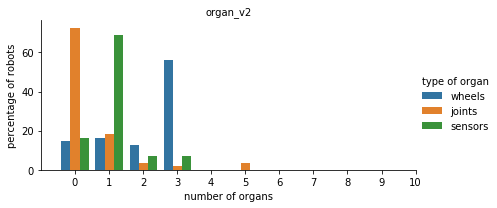

In [34]:
fig = plt.gcf()
fig.set_size_inches(5, 5)
organs_data = pd.DataFrame(data=organ_lines,columns=["number of organs","percentage of robots","type of organ","variant"])
g=sns.catplot(data=organs_data,x="number of organs",y="percentage of robots",hue="type of organ",col="variant",kind='bar',col_wrap=1,aspect=2,height=3)
(g.set_titles("{col_name}")
  .set(xlim=(-1, 10))) 

[]


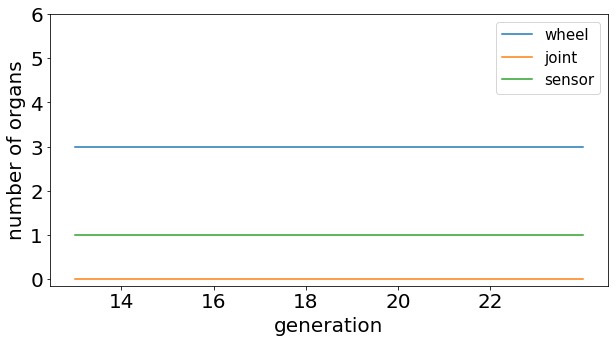

In [35]:
data = pd.DataFrame(data=best_desc_lines,columns=["generation","wheel","sensor","joint"])
fig = plt.gcf()
fig.set_size_inches(10,5)
ax = sns.lineplot(data=data,x="generation",y="wheel",label="wheel")
sns.lineplot(data=data,x="generation",y="joint",label="joint")
sns.lineplot(data=data,x="generation",y="sensor",label="sensor")
ax.set_xticks(range(14,24,2))
ax.set_yticks(range(7))
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.set_ylabel("number of organs")
#ax.set_title(arena, fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
wheels_array = data.loc[data["generation"]==9]["wheel"].values
joints_array = data.loc[data["generation"]==9]["joint"].values
sensors_array = data.loc[data["generation"]==9]["sensor"].values
bda = [[w,s,j]for w,s,j in zip(wheels_array,sensors_array,joints_array)]
print(bda)